# Circle Cover Algorithm - Results Visualization

This notebook visualizes the results of the Greedy Submodular Circle Cover algorithm.

## Contents
1. Load experiment data
2. Visualize point distribution
3. Show selected circles
4. Coverage progression analysis
5. Performance metrics
6. MapReduce insights

In [1]:
# !pip3 install matplotlib numpy pandas seaborn

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import seaborn as sns

# Add parent directory to path
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Imports successful!")

Imports successful!


## 1. Configuration and Data Loading

In [3]:
# Configuration - update this path to your experiment results
EXPERIMENT_NAME = "small_experiment"  # Change to: small_experiment, medium_experiment, large_experiment
DATA_DIR = f"../data/results/{EXPERIMENT_NAME}/data"
RESULTS_DIR = f"../data/results/{EXPERIMENT_NAME}/results"

print(f"Loading data from: {EXPERIMENT_NAME}")
print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Loading data from: small_experiment
Data directory: ../data/results/small_experiment/data
Results directory: ../data/results/small_experiment/results


In [4]:
# Initialize Spark for reading Parquet files
import os
os.environ['SPARK_HOME'] = '/opt/homebrew/Cellar/apache-spark/4.0.1_1/libexec'
os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home'
os.environ['PATH'] = '/opt/homebrew/opt/openjdk@17/bin:' + os.environ.get('PATH', '')

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ResultsVisualization") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
print("Spark session started")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/03 16:54:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session started


In [5]:
# Load points
points_df = spark.read.parquet(f"{DATA_DIR}/points")
points_pd = points_df.toPandas()

print(f"Loaded {len(points_pd)} points")
print("\nPoints schema:")
points_df.printSchema()
print("\nFirst 5 points:")
points_pd.head()

Loaded 10000 points

Points schema:
root
 |-- point_id: long (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- cluster_id: integer (nullable = true)


First 5 points:


,point_id,x,y,cluster_id
0,9695,895.147159,788.144014,NaN
1,9696,126.525676,610.307782,NaN
2,9697,995.906640,595.550701,NaN
3,9698,785.871626,769.061473,NaN
4,9699,350.317526,371.849303,NaN


In [6]:
# Load circles
circles_df = spark.read.parquet(f"{DATA_DIR}/circles")
circles_pd = circles_df.toPandas()

print(f"Loaded {len(circles_pd)} circles")
print("\nCircles schema:")
circles_df.printSchema()
print("\nFirst 5 circles:")
circles_pd.head()

Loaded 1000 circles

Circles schema:
root
 |-- circle_id: long (nullable = true)
 |-- center_x: double (nullable = true)
 |-- center_y: double (nullable = true)
 |-- radius: double (nullable = true)
 |-- metadata: string (nullable = true)


First 5 circles:


,circle_id,center_x,center_y,radius,metadata
0,459,763.605794,140.113176,50.0,None
1,460,868.467976,487.431198,50.0,None
2,461,894.552227,799.855256,50.0,None
3,462,425.213504,22.469308,50.0,None
4,463,268.677359,541.634215,50.0,None


In [7]:
# Load iteration results
results_df = spark.read.parquet(RESULTS_DIR)
results_pd = results_df.toPandas()

print(f"Loaded {len(results_pd)} iterations")
print("\nResults schema:")
results_df.printSchema()
print("\nIteration results:")
results_pd

Loaded 5 iterations

Results schema:
root
 |-- iteration: integer (nullable = true)
 |-- selected_circle_id: long (nullable = true)
 |-- gain: long (nullable = true)
 |-- cumulative_coverage: long (nullable = true)
 |-- duration_sec: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)


Iteration results:


,iteration,selected_circle_id,gain,cumulative_coverage,duration_sec,timestamp
0,1,148,104,104,4.879656,2026-01-03 16:53:47.682608
1,4,862,102,413,5.053714,2026-01-03 16:54:02.523998
2,2,940,104,208,4.847036,2026-01-03 16:53:52.529675
3,3,246,103,311,4.940544,2026-01-03 16:53:57.470259
4,5,322,101,514,4.725314,2026-01-03 16:54:07.249337


## 2. Point Distribution Visualization

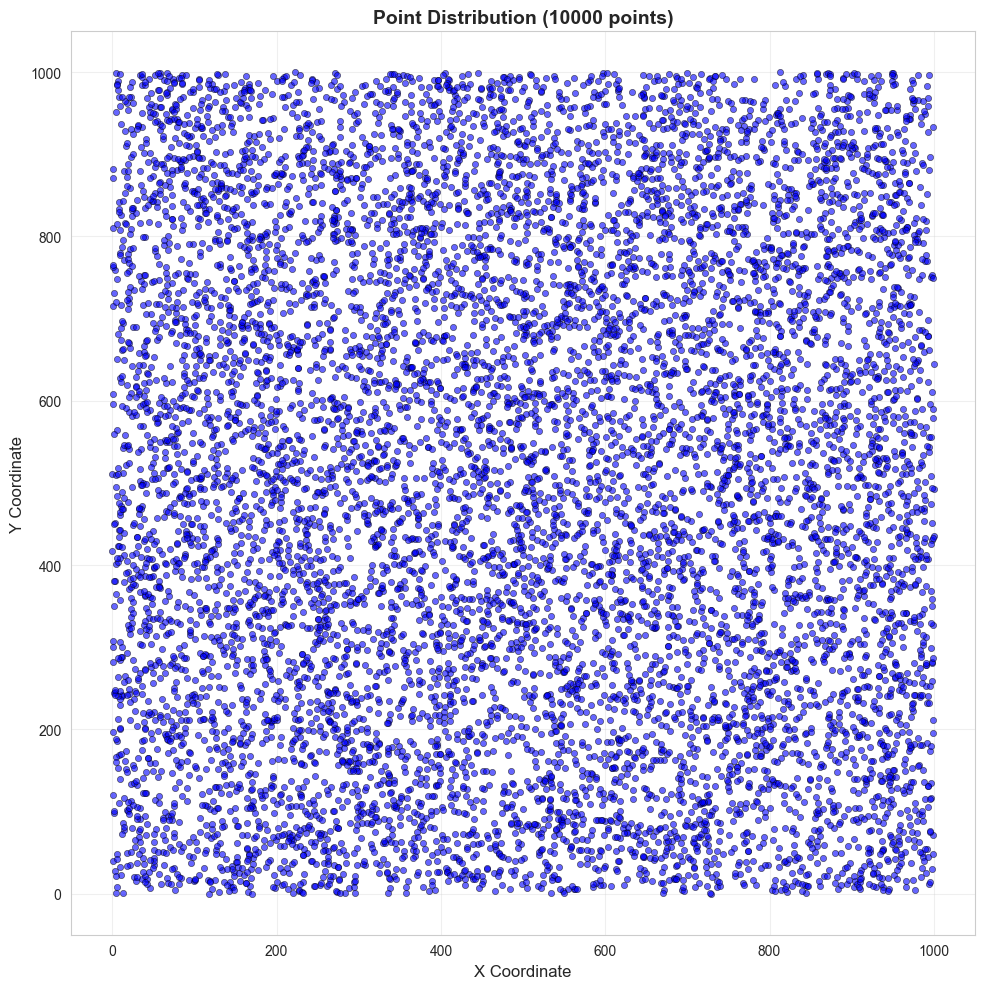


Point Statistics:
  X range: [0.01, 999.92]
  Y range: [0.03, 999.72]
  X mean: 498.47, std: 288.01
  Y mean: 500.22, std: 289.00


In [8]:
# Visualize all points
fig, ax = plt.subplots(figsize=(14, 10))

# Plot points
if 'cluster_id' in points_pd.columns and points_pd['cluster_id'].notna().any():
    # Colored by cluster
    scatter = ax.scatter(points_pd['x'], points_pd['y'], 
                        c=points_pd['cluster_id'], 
                        cmap='tab20', 
                        alpha=0.6, 
                        s=20,
                        edgecolors='black',
                        linewidth=0.5)
    plt.colorbar(scatter, ax=ax, label='Cluster ID')
else:
    # Uniform color
    ax.scatter(points_pd['x'], points_pd['y'], 
              alpha=0.6, 
              s=20,
              c='blue',
              edgecolors='black',
              linewidth=0.5)

ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title(f'Point Distribution ({len(points_pd)} points)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Statistics
print(f"\nPoint Statistics:")
print(f"  X range: [{points_pd['x'].min():.2f}, {points_pd['x'].max():.2f}]")
print(f"  Y range: [{points_pd['y'].min():.2f}, {points_pd['y'].max():.2f}]")
print(f"  X mean: {points_pd['x'].mean():.2f}, std: {points_pd['x'].std():.2f}")
print(f"  Y mean: {points_pd['y'].mean():.2f}, std: {points_pd['y'].std():.2f}")

## 3. Selected Circles Visualization

In [9]:
# Get selected circle IDs
selected_circle_ids = results_pd['selected_circle_id'].tolist()
selected_circles = circles_pd[circles_pd['circle_id'].isin(selected_circle_ids)]

print(f"Selected {len(selected_circles)} circles:")
print(selected_circle_ids)

Selected 5 circles:
[148, 862, 940, 246, 322]


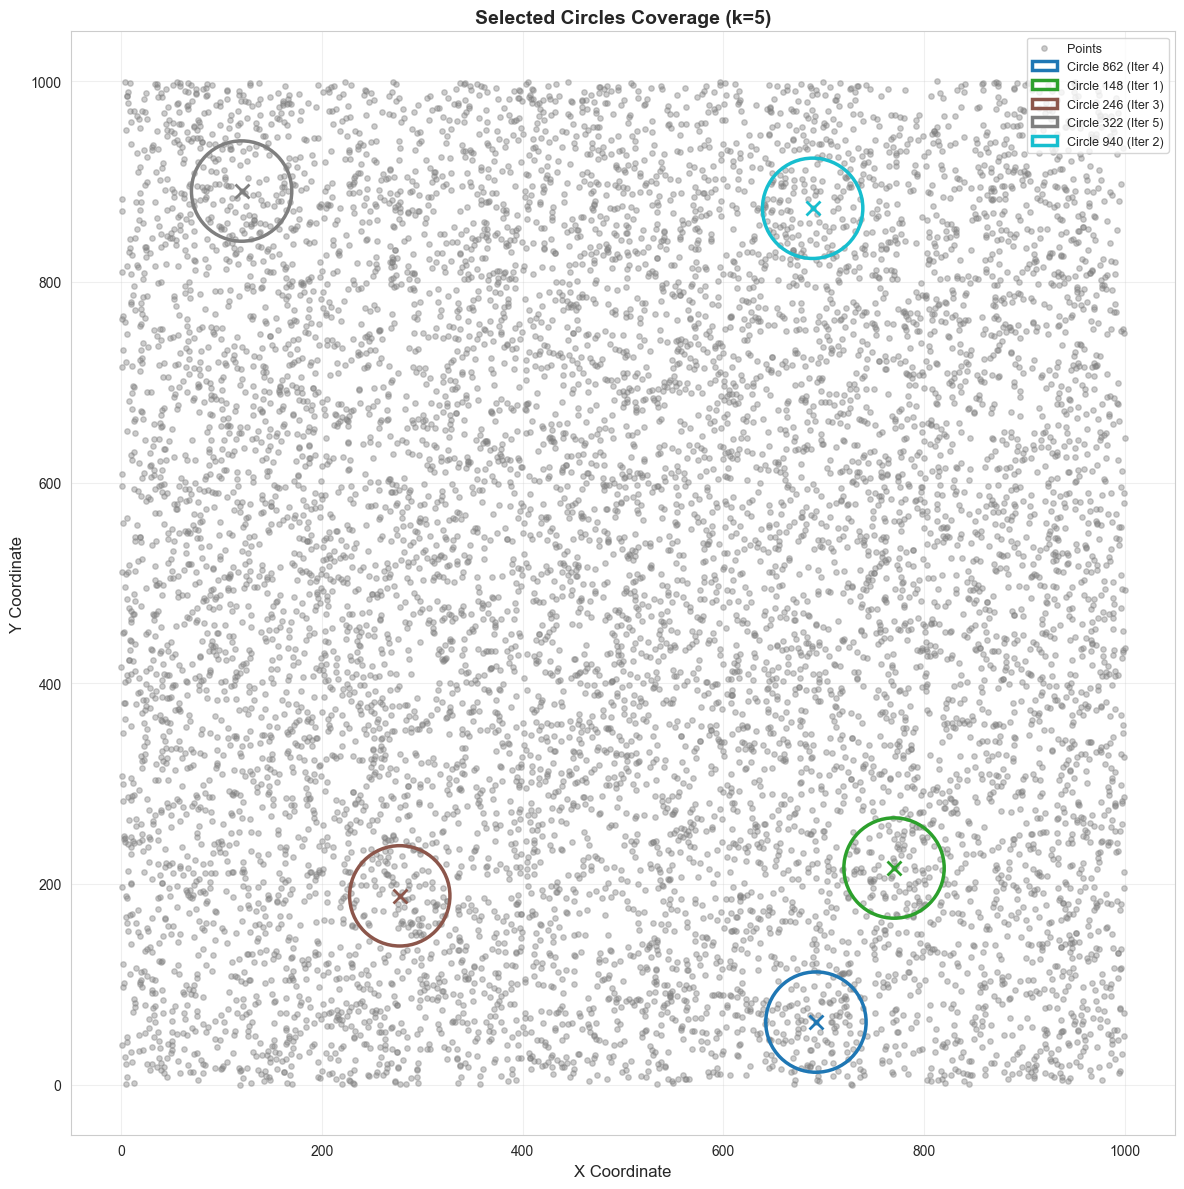

In [10]:
# Visualize points with selected circles
fig, ax = plt.subplots(figsize=(16, 12))

# Plot all points (gray)
ax.scatter(points_pd['x'], points_pd['y'], 
          alpha=0.4, 
          s=15,
          c='gray',
          label='Points')

# Plot selected circles
colors = plt.cm.tab10(np.linspace(0, 1, len(selected_circles)))

for idx, (_, circle) in enumerate(selected_circles.iterrows()):
    # Find iteration when this circle was selected
    iteration = results_pd[results_pd['selected_circle_id'] == circle['circle_id']]['iteration'].values[0]
    
    # Draw circle
    circle_patch = plt.Circle(
        (circle['center_x'], circle['center_y']), 
        circle['radius'],
        color=colors[idx],
        fill=False,
        linewidth=2.5,
        label=f"Circle {circle['circle_id']} (Iter {iteration})"
    )
    ax.add_patch(circle_patch)
    
    # Mark center
    ax.plot(circle['center_x'], circle['center_y'], 
           marker='x', 
           markersize=10, 
           color=colors[idx],
           markeredgewidth=2)

ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title(f'Selected Circles Coverage (k={len(selected_circles)})', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 4. Coverage Progression Analysis

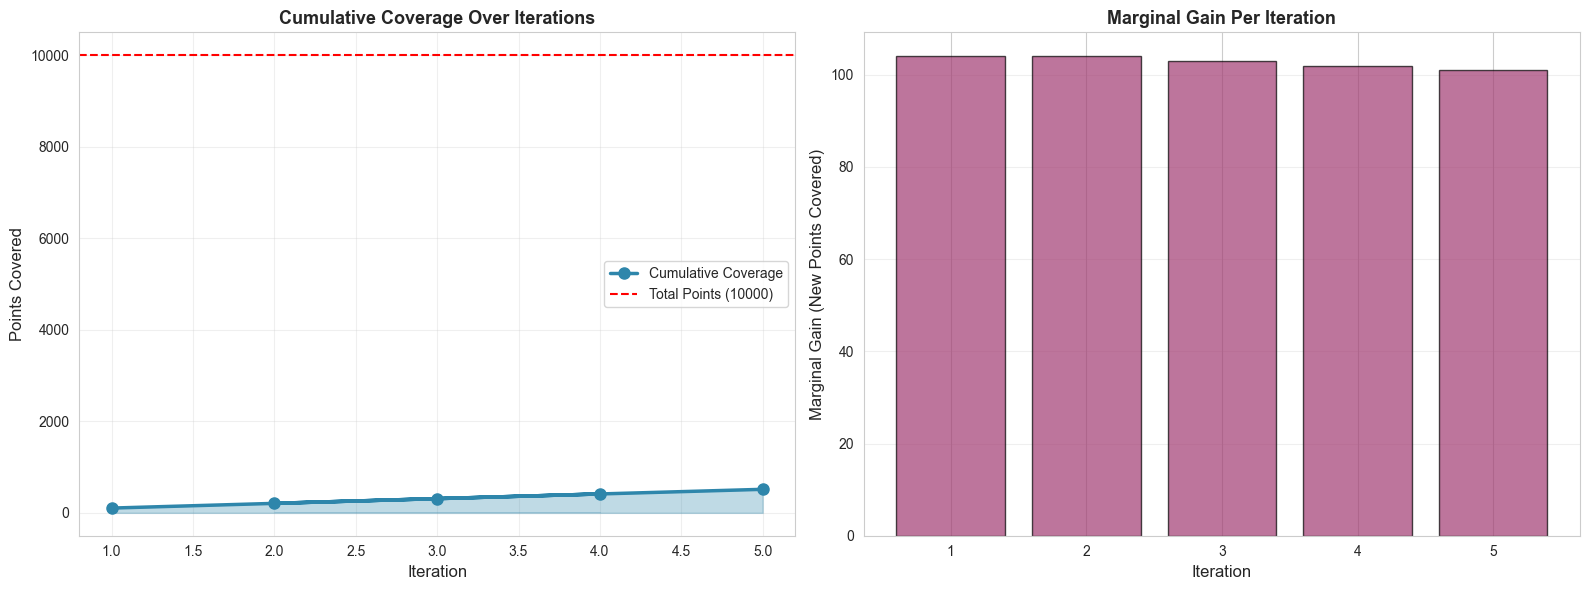


Coverage Statistics:
  Final coverage: 514/10000 points (5.14%)
  Average gain per iteration: 102.80
  Max gain: 104 (iteration 1)
  Min gain: 101 (iteration 5)


In [11]:
# Coverage over iterations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Cumulative coverage
iterations = results_pd['iteration']
cumulative_coverage = results_pd['cumulative_coverage']
total_points = len(points_pd)

ax1.plot(iterations, cumulative_coverage, 
         marker='o', 
         linewidth=2.5, 
         markersize=8,
         color='#2E86AB',
         label='Cumulative Coverage')
ax1.axhline(y=total_points, color='red', linestyle='--', linewidth=1.5, label=f'Total Points ({total_points})')
ax1.fill_between(iterations, cumulative_coverage, alpha=0.3, color='#2E86AB')

ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Points Covered', fontsize=12)
ax1.set_title('Cumulative Coverage Over Iterations', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Marginal gain per iteration
gains = results_pd['gain']

ax2.bar(iterations, gains, 
        color='#A23B72', 
        alpha=0.7,
        edgecolor='black',
        linewidth=1)

ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Marginal Gain (New Points Covered)', fontsize=12)
ax2.set_title('Marginal Gain Per Iteration', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print coverage statistics
final_coverage = cumulative_coverage.iloc[-1]
coverage_pct = 100.0 * final_coverage / total_points

print(f"\nCoverage Statistics:")
print(f"  Final coverage: {final_coverage}/{total_points} points ({coverage_pct:.2f}%)")
print(f"  Average gain per iteration: {gains.mean():.2f}")
print(f"  Max gain: {gains.max()} (iteration {gains.idxmax() + 1})")
print(f"  Min gain: {gains.min()} (iteration {gains.idxmin() + 1})")

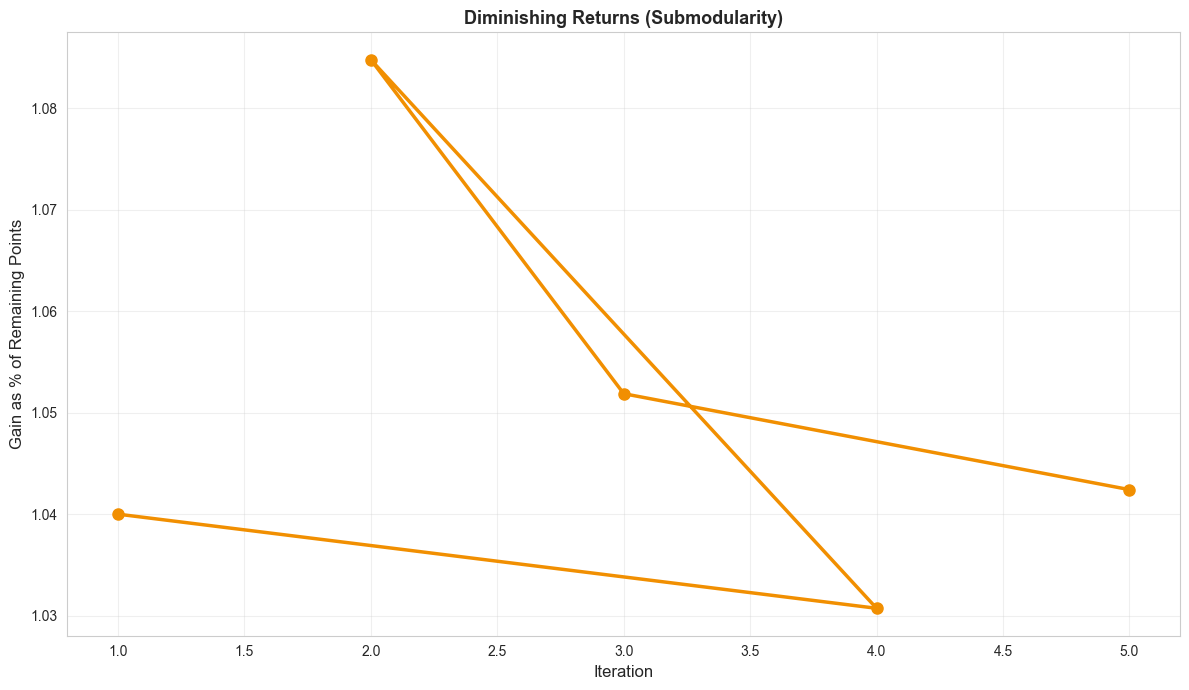


Note: Decreasing trend demonstrates submodular property (diminishing returns)


In [12]:
# Diminishing returns analysis
fig, ax = plt.subplots(figsize=(12, 7))

# Plot gain as percentage of remaining points
remaining_points = [total_points - cumulative_coverage.iloc[i-1] if i > 0 else total_points 
                   for i in range(len(results_pd))]
gain_ratio = [gains.iloc[i] / remaining_points[i] * 100 if remaining_points[i] > 0 else 0 
             for i in range(len(results_pd))]

ax.plot(iterations, gain_ratio, 
        marker='o', 
        linewidth=2.5, 
        markersize=8,
        color='#F18F01')

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Gain as % of Remaining Points', fontsize=12)
ax.set_title('Diminishing Returns (Submodularity)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: Decreasing trend demonstrates submodular property (diminishing returns)")

## 5. Performance Metrics

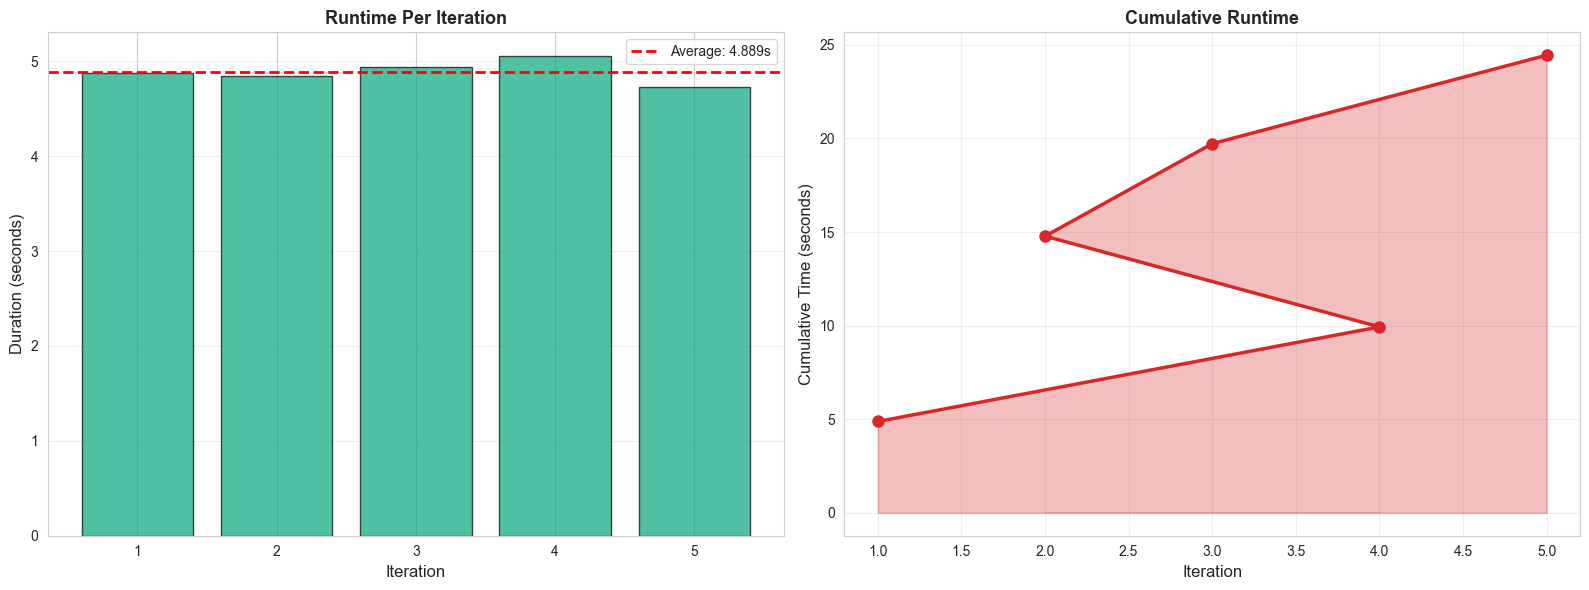


Performance Statistics:
  Total runtime: 24.446 seconds (0.41 minutes)
  Average iteration time: 4.889 seconds
  Fastest iteration: 4.725s (iteration 5)
  Slowest iteration: 5.054s (iteration 2)
  Points covered per second: 21.03


In [13]:
# Runtime analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Duration per iteration
durations = results_pd['duration_sec']

ax1.bar(iterations, durations, 
        color='#06A77D', 
        alpha=0.7,
        edgecolor='black',
        linewidth=1)
ax1.axhline(y=durations.mean(), 
           color='red', 
           linestyle='--', 
           linewidth=2, 
           label=f'Average: {durations.mean():.3f}s')

ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Duration (seconds)', fontsize=12)
ax1.set_title('Runtime Per Iteration', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Cumulative runtime
cumulative_time = durations.cumsum()

ax2.plot(iterations, cumulative_time, 
         marker='o', 
         linewidth=2.5, 
         markersize=8,
         color='#D62828')
ax2.fill_between(iterations, cumulative_time, alpha=0.3, color='#D62828')

ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Cumulative Time (seconds)', fontsize=12)
ax2.set_title('Cumulative Runtime', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance statistics
total_time = durations.sum()
avg_time = durations.mean()

print(f"\nPerformance Statistics:")
print(f"  Total runtime: {total_time:.3f} seconds ({total_time/60:.2f} minutes)")
print(f"  Average iteration time: {avg_time:.3f} seconds")
print(f"  Fastest iteration: {durations.min():.3f}s (iteration {durations.idxmin() + 1})")
print(f"  Slowest iteration: {durations.max():.3f}s (iteration {durations.idxmax() + 1})")
print(f"  Points covered per second: {final_coverage / total_time:.2f}")

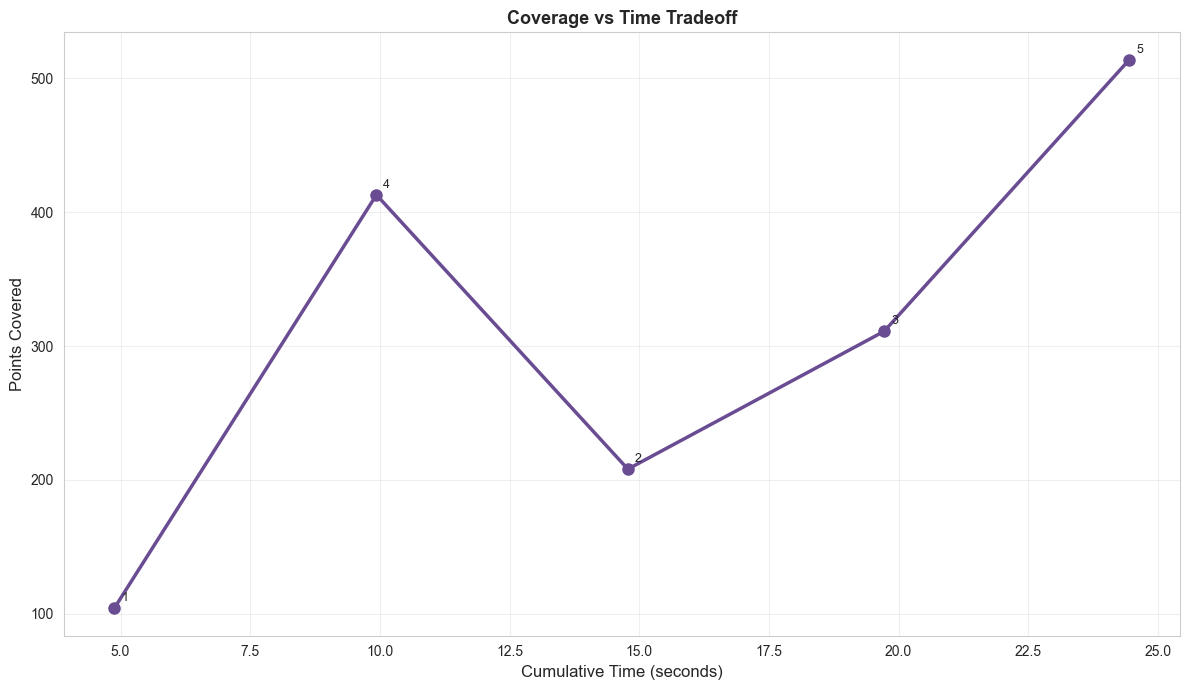

In [14]:
# Efficiency: coverage vs time tradeoff
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(cumulative_time, cumulative_coverage, 
        marker='o', 
        linewidth=2.5, 
        markersize=8,
        color='#6A4C93')

# Add annotations for each iteration
for i, (time, cov, iter_num) in enumerate(zip(cumulative_time, cumulative_coverage, iterations)):
    ax.annotate(f'{iter_num}', 
               xy=(time, cov), 
               xytext=(5, 5), 
               textcoords='offset points',
               fontsize=9)

ax.set_xlabel('Cumulative Time (seconds)', fontsize=12)
ax.set_ylabel('Points Covered', fontsize=12)
ax.set_title('Coverage vs Time Tradeoff', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Iteration Details Table

In [15]:
# Create detailed summary table
summary = results_pd[['iteration', 'selected_circle_id', 'gain', 'cumulative_coverage', 'duration_sec']].copy()
summary['coverage_pct'] = (summary['cumulative_coverage'] / total_points * 100).round(2)
summary['gain_pct'] = (summary['gain'] / total_points * 100).round(2)
summary['duration_sec'] = summary['duration_sec'].round(3)

print("\nIteration Summary:")
print("=" * 100)
summary


Iteration Summary:


,iteration,selected_circle_id,gain,cumulative_coverage,duration_sec,coverage_pct,gain_pct
0,1,148,104,104,4.880,1.04,1.04
1,4,862,102,413,5.054,4.13,1.02
2,2,940,104,208,4.847,2.08,1.04
3,3,246,103,311,4.941,3.11,1.03
4,5,322,101,514,4.725,5.14,1.01


## 7. MapReduce Insights

In [16]:
# Calculate MapReduce statistics
k = len(results_pd)
n_points = len(points_pd)
n_circles = len(circles_pd)

print("\n" + "="*70)
print("MAPREDUCE ANALYSIS")
print("="*70)

print(f"\nDataset:")
print(f"  Points (n): {n_points:,}")
print(f"  Candidate circles (m): {n_circles:,}")
print(f"  Selected circles (k): {k}")

print(f"\nStage Analysis:")
print(f"  Expected stages per iteration: 3")
print(f"    - Stage 1: MAP (compute gains)")
print(f"    - Stage 2: REDUCE (aggregate & find best)")
print(f"    - Stage 3: MAP (update coverage)")
print(f"  Total stages for k={k}: ~{k * 3}")

print(f"\nComplexity:")
print(f"  Theoretical: O(k × m × n) = O({k} × {n_circles} × {n_points})")
print(f"  = {k * n_circles * n_points:,} operations")

print(f"\nActual Performance:")
print(f"  Total runtime: {total_time:.3f}s")
print(f"  Operations per second: {(k * n_circles * n_points) / total_time:,.0f}")

# Estimate data sizes
point_size_bytes = 32  # 8 bytes each for: point_id, x, y, cluster_id
circle_size_bytes = 32  # 8 bytes each for: circle_id, center_x, center_y, radius

points_size_mb = (n_points * point_size_bytes) / (1024 * 1024)
circles_size_mb = (n_circles * circle_size_bytes) / (1024 * 1024)
coverage_status_mb = n_points / (1024 * 1024)  # 1 byte per point

print(f"\nEstimated Data Sizes:")
print(f"  Points: {points_size_mb:.2f} MB")
print(f"  Circles (broadcast): {circles_size_mb:.2f} MB")
print(f"  Coverage status (broadcast): {coverage_status_mb:.2f} MB")
print(f"  Total broadcast: {circles_size_mb + coverage_status_mb:.2f} MB")

if circles_size_mb + coverage_status_mb < 100:
    print(f"  ✓ Broadcast size < 100 MB (suitable for broadcast)")
else:
    print(f"  ⚠ Broadcast size > 100 MB (consider distributed approach)")


MAPREDUCE ANALYSIS

Dataset:
  Points (n): 10,000
  Candidate circles (m): 1,000
  Selected circles (k): 5

Stage Analysis:
  Expected stages per iteration: 3
    - Stage 1: MAP (compute gains)
    - Stage 2: REDUCE (aggregate & find best)
    - Stage 3: MAP (update coverage)
  Total stages for k=5: ~15

Complexity:
  Theoretical: O(k × m × n) = O(5 × 1000 × 10000)
  = 50,000,000 operations

Actual Performance:
  Total runtime: 24.446s
  Operations per second: 2,045,302

Estimated Data Sizes:
  Points: 0.31 MB
  Circles (broadcast): 0.03 MB
  Coverage status (broadcast): 0.01 MB
  Total broadcast: 0.04 MB
  ✓ Broadcast size < 100 MB (suitable for broadcast)


## 8. Approximation Quality Analysis

In [17]:
# Compare against baseline (random selection)
# Estimate random selection coverage

# For random selection, estimate expected coverage
# This is approximate - actual would require simulation
avg_circle_coverage = circles_pd['radius'].mean() ** 2 * np.pi / ((points_pd['x'].max() - points_pd['x'].min()) * (points_pd['y'].max() - points_pd['y'].min())) * n_points

# Estimate random selection (without overlap consideration - upper bound)
random_estimate = min(k * avg_circle_coverage, n_points)

print("\n" + "="*70)
print("APPROXIMATION QUALITY")
print("="*70)

print(f"\nGreedy Algorithm Results:")
print(f"  Coverage: {final_coverage}/{n_points} points ({coverage_pct:.2f}%)")

print(f"\nEstimated Random Baseline:")
print(f"  Expected coverage: ~{random_estimate:.0f} points ({100*random_estimate/n_points:.2f}%)")

if final_coverage > random_estimate:
    improvement = (final_coverage / random_estimate - 1) * 100
    print(f"  ✓ Greedy outperforms random by ~{improvement:.1f}%")

print(f"\nSubmodular Properties:")
# Check if gains are monotonically decreasing (submodular diminishing returns)
is_decreasing = all(gains.iloc[i] >= gains.iloc[i+1] for i in range(len(gains)-1))
if is_decreasing:
    print(f"  ✓ Gains are monotonically decreasing (strong submodularity)")
else:
    print(f"  ~ Gains not strictly decreasing (typical for coverage problems with overlap)")
    
print(f"\nTheoretical Guarantees:")
print(f"  Greedy submodular: ≥ 0.5 approximation to optimal")
print(f"  For monotone submodular: (1 - 1/e) ≈ 0.632 approximation")


APPROXIMATION QUALITY

Greedy Algorithm Results:
  Coverage: 514/10000 points (5.14%)

Estimated Random Baseline:
  Expected coverage: ~393 points (3.93%)
  ✓ Greedy outperforms random by ~30.8%

Submodular Properties:
  ~ Gains not strictly decreasing (typical for coverage problems with overlap)

Theoretical Guarantees:
  Greedy submodular: ≥ 0.5 approximation to optimal
  For monotone submodular: (1 - 1/e) ≈ 0.632 approximation


## 9. Save Visualizations

In [18]:
# Create output directory for plots
output_dir = f"../data/results/{EXPERIMENT_NAME}/visualizations"
os.makedirs(output_dir, exist_ok=True)

print(f"\nSaving visualizations to: {output_dir}")
print("(Re-run the plotting cells above after creating output_dir to save figures)")


Saving visualizations to: ../data/results/small_experiment/visualizations
(Re-run the plotting cells above after creating output_dir to save figures)


## 10. Summary Report

In [19]:
print("\n" + "="*70)
print("EXPERIMENT SUMMARY REPORT")
print("="*70)

print(f"\nExperiment: {EXPERIMENT_NAME}")
print(f"Timestamp: {results_pd['timestamp'].min()}")

print(f"\n1. DATASET")
print(f"   - Points: {n_points:,}")
print(f"   - Candidate circles: {n_circles:,}")
print(f"   - Budget k: {k}")

print(f"\n2. RESULTS")
print(f"   - Final coverage: {final_coverage:,}/{n_points:,} ({coverage_pct:.2f}%)")
print(f"   - Circles selected: {k}")
print(f"   - Average gain: {gains.mean():.2f} points/circle")

print(f"\n3. PERFORMANCE")
print(f"   - Total runtime: {total_time:.2f}s ({total_time/60:.2f} min)")
print(f"   - Avg iteration: {avg_time:.3f}s")
print(f"   - Throughput: {final_coverage/total_time:.2f} points/sec")

print(f"\n4. EFFICIENCY")
print(f"   - Points per circle: {final_coverage/k:.2f}")
print(f"   - Time per 1000 points: {1000*total_time/final_coverage:.3f}s")

print(f"\n5. ALGORITHM PROPERTIES")
if is_decreasing:
    print(f"   ✓ Submodular diminishing returns observed")
print(f"   ✓ Monotonic coverage increase")
print(f"   ✓ Greedy guarantee: ≥ 0.5 optimal")

print("\n" + "="*70)


EXPERIMENT SUMMARY REPORT

Experiment: small_experiment
Timestamp: 2026-01-03 16:53:47.682608

1. DATASET
   - Points: 10,000
   - Candidate circles: 1,000
   - Budget k: 5

2. RESULTS
   - Final coverage: 514/10,000 (5.14%)
   - Circles selected: 5
   - Average gain: 102.80 points/circle

3. PERFORMANCE
   - Total runtime: 24.45s (0.41 min)
   - Avg iteration: 4.889s
   - Throughput: 21.03 points/sec

4. EFFICIENCY
   - Points per circle: 102.80
   - Time per 1000 points: 47.561s

5. ALGORITHM PROPERTIES
   ✓ Monotonic coverage increase
   ✓ Greedy guarantee: ≥ 0.5 optimal



In [20]:
# Clean up Spark session
spark.stop()
print("\nSpark session stopped.")


Spark session stopped.
